In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

%load_ext autotime

time: 804 µs (started: 2022-05-09 17:38:10 +04:00)


In [2]:
filepath = "../Data/AP_ModelTraining20220118.csv"

data = pd.read_csv(filepath)

time: 2min 37s (started: 2022-05-09 17:38:10 +04:00)


In [3]:
data.shape

(9536327, 232)

time: 8.73 ms (started: 2022-05-09 17:40:47 +04:00)


In [4]:
# Count columns with "Flags" substring, seperating, count NA percentage of each column. Do not touch "lead flag", which is the target column

flags = []
NAs_flag = []
count_rows = data.shape[0]
for col in data.columns:
    if (col.lower().find('Flag'.lower()) != -1) and (col.lower() != 'lead flag'):
        flags.append(col)
        count_nan = data[col].isna().sum() / count_rows * 100
        NAs_flag.append(count_nan)
        
NAs_flags_df = pd.DataFrame({'cols':flags, 'Nas_perc':NAs_flag})

NAs_flags_df

,cols,Nas_perc
0,PrevTargetFlag,15.726306
1,Application Flag,99.041381
2,Approval Flag,99.041381
3,Contracting Flag,99.041381
4,Fulfillment Flag,99.041381
5,Funded Flag,99.041381
6,Cancelled Flag,99.041381
7,ManFlag,0.000000
8,MachineFlag,0.000000
9,ManAndMachineFlag,0.000000


time: 330 ms (started: 2022-05-09 17:40:47 +04:00)


In [5]:
# Dropping columns with "Flag" substring

data = data.drop(flags, axis=1)

time: 22.1 s (started: 2022-05-09 17:40:48 +04:00)


In [6]:
# Identifying columns with "ID" substring, counting NAs percentage of each column

IDs = []
Nas_IDs = []
count_rows = data.shape[0]
for col in data.columns:
    if col.find('ID') != -1:
        IDs.append(col)
        count_nan = data[col].isna().sum() / count_rows * 100
        Nas_IDs.append(count_nan)

time: 48.1 ms (started: 2022-05-09 17:41:10 +04:00)


In [7]:
# Dropping columns with "ID" substring

data = data.drop(IDs, axis=1)

time: 23 s (started: 2022-05-09 17:41:10 +04:00)


In [8]:
# Dropping prediction columns. These will misguide the future steps

data = data.drop(['Predicted', 'Probability'], axis=1)

time: 20.9 s (started: 2022-05-09 17:41:35 +04:00)


In [9]:
# Columns detected manually that need to be removed

remove_cols = [ 'Year', 
                'NumOfOpenBankcardTradesBalDateWithin6MosSingleBalOrCreditRatioGT100PCT', 
                'NumOfOpenFinanceTrades', 
                'NumberofForeclosure',
                'openmortgages_1MO',
                'openandcurrentmortgages_1MO',
                'closedmortgagepast6months_1MO',
                'closedmortgagepast12months_1MO',
                'closedmortgage24months_1MO',
                'openedmortgagepast6months_1MO',
                'openedmortgagepast12months_1MO',
                'openedmortgagepast24months_1MO',
                'AggregateBalanceOfOpenHomeEquityTrades',
                'Endingbalanceofmostrecentlyclosedmortgagetrade_1MO',
                'Ageofmostrecentmortgageinquiry-months',
                'AggTotalStudentCreditLimit',
                'AggTotalStudentScheduledPaymentAmt',
                'AggTotalStudentActualPaymentAmt',
                'AggTotalStudentPastDueAmount',
                'AggTotalStudentChargeOffAmount',
                'Make',
                'Model',
                'DateOfBirth',
                'Education',
                'MAXOpenDateAuto',
                'MAXCloseDateAuto',
                'DatesonmostrecentUnpaidCollectionsExcludingMedical',
                'DatesonsecondmostrecentUnpaidCollectionsExcludingMedical',
                'DatesonthirdmostrecentUnpaidCollectionsExcludingMedical',
                'NonRetailPdWasAndDelqMostRecent',
                'DateofmostrecentForeclosures',
                'DateofsecondmostrecentForeclosures',
                'MortgageMAXOpenDate',
                'MortgageMAXCloseDate',
                'PErsonalLoanMAXdateopened',
                'PErsonalLoanMAXdateclosed',
                'DateofmostrecentRepossession',
                'DateofsecondmostrecentRepossession',
                'OldestStudentLoanDateReported',
                'HighestStudentLoanRateOrStatusCode',
                'CampaignDate',
                'DropDate',
                'ResponseCode',
                'Lead Date',
                'Funded Date',
                'Previous Application Date',
                'monthssincemostrecentlyclosedopenedmortgagetrade_1MO',
                'monthssincemostrecentlyclosedortransferredmtgtrade_1MO',
                'Cummulativecurrentbalanceforallopenmortgagetrades_1MO',
                'Currentbalanceofhighestmortgagetrade_1MO',
                'Originalcreditamountofhighestmortgagetrade_1MO',
                'Cumulativeoriginalcreditamountofallopenmortgagetrades_1MO',
                'UtilizationTotalOfBankCards',
                'HighestRevolvingSingleBalance',
                'NumberOfMortgageTrades',
                'NumberOfActiveTrades',
                'AggCreditForOpenTrades',
                'AggBalToCreditRatioForOpenTrades',
                'NumOfTradesMajorDerog',
                'AggBalForMajorDerog',
                'NumOfNonAutoLoanOrLeaseInquiriesWithin12Mos']

time: 897 µs (started: 2022-05-09 17:41:56 +04:00)


In [10]:
# Removing manually detected unnecessary columns

data = data.drop(remove_cols, axis=1)

time: 13.5 s (started: 2022-05-09 17:41:56 +04:00)


In [11]:
# Finding columns of type object that will need to be splitted to make numeric
obj_cols_to_transform = list(data.select_dtypes(include=['object']).columns)

time: 413 ms (started: 2022-05-09 17:42:09 +04:00)


In [12]:
# Splitting the object columns into columns of values 1s and 0s 

for col in obj_cols_to_transform:
    col_values = data[col].unique()
    for val in col_values:
        data[col + "_" + str(val)] = np.where(data[col] == val, 1, 0)

time: 16.9 s (started: 2022-05-09 17:42:10 +04:00)


In [13]:
# Dropping all the object columns, not useful anymore

data = data.drop(obj_cols_to_transform, axis=1)

time: 20.3 s (started: 2022-05-09 17:42:27 +04:00)


In [14]:
# Some columns' missing values are known how to be filled. The information about these columns was provided along with the data
# Below column names are columns whose missing values will be filled by 0s.

NAs_cols = [    'NumberOfBankruptciesFiled',
                'NumberOfBankruptciesDischarged',
                'NumberOfBankruptciesDismissed',
                'NumberOfBankruptciesDisposed',
                'mortgageinquiriespast3months',
                'mortgageinquiriespast6months',
                'HighestbalanceofopenVAloan_1MO',
                'CumulativebalancesofopenVAloan_1MO',
                '30daylatepast3months_1MO',
                '60daylatethepast3months_1MO',
                '90dayormorelatepast3months_1MO',
                '30daylatepast6months_1MO',
                '60daylatepast6months_1MO',
                '90ormoredaylatepast6months_1MO',
                '30daylatepast12months_1MO',
                '60daylatepast12months_1MO',
                '90dayormorelatepast12months_1MO',
                'dayspastduecurrently_1MO',
                'FHAloans_1MO',
                'openVAloans_1MO',
                'openFinanceMortgageloans_1MO',
                'MortgageOpenTradeLines',
                'MortgageSumPayment',
                'MortgageSumBalance',
                'Numberof60DPDwithinthelast12months',
                'Numberof60DPDwithinthelast18months',
                'Numberof90DPDwithinthelast12months',
                'Numberof90DPDwithinthelast18months',
                'WeeksSinceLastTarget',
                'DaysSinceLastTarget',
                'AgeOfOldestOpenAndCurrentRevolvingTrade',
                'NumOfOpenAndCurrentFinanceTrades',
                'HighestRevolvingCreditAmount',
                'KeycodedAggBalCredLimitRatioForOpenRevolvingTrades',
                'MinBalToCreditOpenAuto',
                'MaxBalToCreditOpenAuto',
                'FICOTier',
                'TargetedInLast30',
                'TargetedInLast60',
                'TargetedInLast90',
                'TargetedInLast180',
                'TimesTargetedLast30',
                'TimesTargetedLast60',
                'TimesTargetedLast90',
                'TimesTargetedLast180',
                'TimesTargeted',
                'AnnualPercentageRate',
                'Payment',
                'MonthsSinceOpen']

time: 591 µs (started: 2022-05-09 17:42:47 +04:00)


In [15]:
# Filling columns' missing values by 0s.

for col in NAs_cols:
    data[col] = data[col].fillna(0)

time: 3.72 s (started: 2022-05-09 17:42:47 +04:00)


In [16]:
# Below column names are columns whose missing values will be filled by column means.

mean_cols = [   'Age',
                'FICO5Score',
                'FICO8Score',
                'FICO8AutoScore',
                'FICO9Score',
                'FICO9AutoScore',
                'Monthlypaymentamountofhighestmortgagetrade_1MO',
                'Cumulativemonthlypaymentsforallopenmortgagetrades_1MO',
                'BalanceofopenFHAloan_1MO',
                'CumulativebalancesofopenFHAloan_1MO',
                'AgeofmostrecentFHAmortgagetrade_1MO',
                'AgeofmostrecentVAmortgagetrade_1MO',
                'BalanceofopenFinanceMortgage_1MO',
                'CumulativebalancesofopenFinanceloan_1MO',
                'AgeofmostrecentFinancemortgagetrade_1MO',
                'MortgageSumHighCredit',
                'PErsonalLoanSumPayment',
                'PErsonalLoanSumHighCredit',
                '3MonthFICO5Delta',
                '6MonthFICO5Delta',
                '12MonthFICO5Delta',
                '18MonthFICO5Delta',
                '3MonthFICOAutoDelta',
                '6MonthFICOAutoDelta',
                '12MonthFICOAutoDelta',
                '18MonthFICOAutoDelta',
                'MonthsSinceMostRecentMortgageOpened',
                'MortgageLTV']

time: 227 µs (started: 2022-05-09 17:42:51 +04:00)


In [17]:
# Filling columns' missing values by column means.

for col in mean_cols:
    mean_value = data[col].mean()
    data[col].fillna(value = mean_value, inplace=True)

time: 2.37 s (started: 2022-05-09 17:42:51 +04:00)


In [18]:
# Checking percentage of missing values of each column.

Nas = []
count_rows = data.shape[0]
for col in data.columns:
    count_nan = data[col].isna().sum() / count_rows * 100
    Nas.append(count_nan)
NAs_df = pd.DataFrame({'cols':data.columns, 'Nas_perc':Nas})
NAs_df = NAs_df.sort_values(by=['Nas_perc'], ascending=False)
NAs_df

,cols,Nas_perc
136,Lead Flag,99.041381
117,MonthsSinceLastRepossession,96.683482
116,NumberofRepossessions,96.683482
115,PErsonalLoanSumBalance,79.332137
129,HomeValue,73.765633
...,...,...
92,mortgageinquiriespast6months,0.000000
91,mortgageinquiriespast3months,0.000000
90,dayspastduecurrently_1MO,0.000000
89,90dayormorelatepast12months_1MO,0.000000


time: 4.08 s (started: 2022-05-09 17:42:53 +04:00)


In [19]:
# Splitting the dataframe into train and test sets. Lead Flag and ZIPCode are saved for the future concatination back to dataframe.

x = data.drop(['Lead Flag'], axis=1)
y = data['Lead Flag'].fillna(0)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)

train_zip_code = x_train['ZIPCode']
test_zip_code = x_test['ZIPCode']

x_train.drop('ZIPCode', axis = 1)
x_test.drop('ZIPCode', axis = 1)

,FICOAutoScore,AutoTradeline,AnnualPercentageRate,Payment,RemainingMonths,Balance,MonthsSinceOpen,TermInMonths,HighCredit,OfferTerm,...,Typecodeformostrecentlyopenedmortgagetrade_1MO_RZ,Typecodeformostrecentlyopenedmortgagetrade_1MO_VS,Typecodeformostrecentlyopenedmortgagetrade_1MO_ZZ,Typecodeformostrecentlyopenedmortgagetrade_1MO_FF,Typecodeformostrecentlyopenedmortgagetrade_1MO_FP,Typecodeformostrecentlyopenedmortgagetrade_1MO_VF,Typecodeformostrecentlyopenedmortgagetrade_1MO_ON,Typecodeformostrecentlyopenedmortgagetrade_1MO_VC,Typecodeformostrecentlyopenedmortgagetrade_1MO_FA,Typecodeformostrecentlyopenedmortgagetrade_1MO_DZ
9358028,660,1.0,8.63,589.0,61.0,31150.0,14.0,75.0,34051.0,71,...,0,0,0,0,0,0,0,0,0,0
2837148,654,1.0,15.15,461.0,59.0,20062.0,16.0,75.0,22264.0,71,...,0,0,0,0,0,0,0,0,0,0
8142723,802,1.0,8.08,316.0,57.0,15025.0,15.0,72.0,17982.0,69,...,0,0,0,0,0,0,0,0,0,0
5936718,632,1.0,14.34,382.0,56.0,16189.0,16.0,72.0,18378.0,68,...,0,0,0,0,0,0,0,0,0,0
5584259,701,1.0,14.43,507.0,41.0,16833.0,31.0,72.0,24330.0,52,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5190249,626,1.0,20.67,449.0,58.0,17015.0,14.0,72.0,18447.0,59,...,0,0,0,0,0,0,0,0,0,0
5233036,692,1.0,7.25,299.0,63.0,15787.0,9.0,72.0,17416.0,71,...,0,0,0,0,0,0,0,0,0,0
8157147,683,1.0,8.19,458.0,64.0,24664.0,9.0,73.0,26266.0,71,...,0,0,0,0,0,0,0,0,0,0
2217022,692,1.0,18.24,416.0,66.0,17863.0,6.0,72.0,18132.0,67,...,0,0,0,0,0,0,0,0,0,0


time: 59 s (started: 2022-05-09 17:42:57 +04:00)


In [20]:
# Running LightGBM Classifier to see feature importance and to further save only important features from the dataframe's all features.

model = lgb.LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)
model.fit(x_train,y_train) 

LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

time: 1min 17s (started: 2022-05-09 17:43:56 +04:00)


In [21]:
# Getting important features, constructing a dataframe.

model.booster_.feature_importance()
fea_imp_ = pd.DataFrame({'cols':x_train.columns, 'fea_imp':model.feature_importances_})
df=fea_imp_.loc[fea_imp_.fea_imp > 0].sort_values(by=['fea_imp'], ascending = False)
imp_var = df.reset_index(drop = True)

time: 38.8 ms (started: 2022-05-09 17:45:13 +04:00)


In [22]:
# Saving only features whose importance gain is greater than 0.

x_train_lgbm = x_train[imp_var.cols]
x_test_lgbm = x_test[imp_var.cols] 

time: 8.56 s (started: 2022-05-09 17:45:13 +04:00)


In [23]:
# Running the LightGBM Classifier again to get cleaner result, only on the features whose importance gain is greater than 0.

model = lgb.LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)
model.fit(x_train_lgbm,y_train)

LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

time: 1min 6s (started: 2022-05-09 17:45:22 +04:00)


In [24]:
# Constructing important features' dataframe.

model.booster_.feature_importance()
fea_imp_ = pd.DataFrame({'cols':x_train_lgbm.columns, 'fea_imp':model.feature_importances_})
df=fea_imp_.loc[fea_imp_.fea_imp > 0].sort_values(by=['fea_imp'], ascending = False)
imp_var = df.reset_index(drop = True)

time: 5.33 ms (started: 2022-05-09 17:46:29 +04:00)


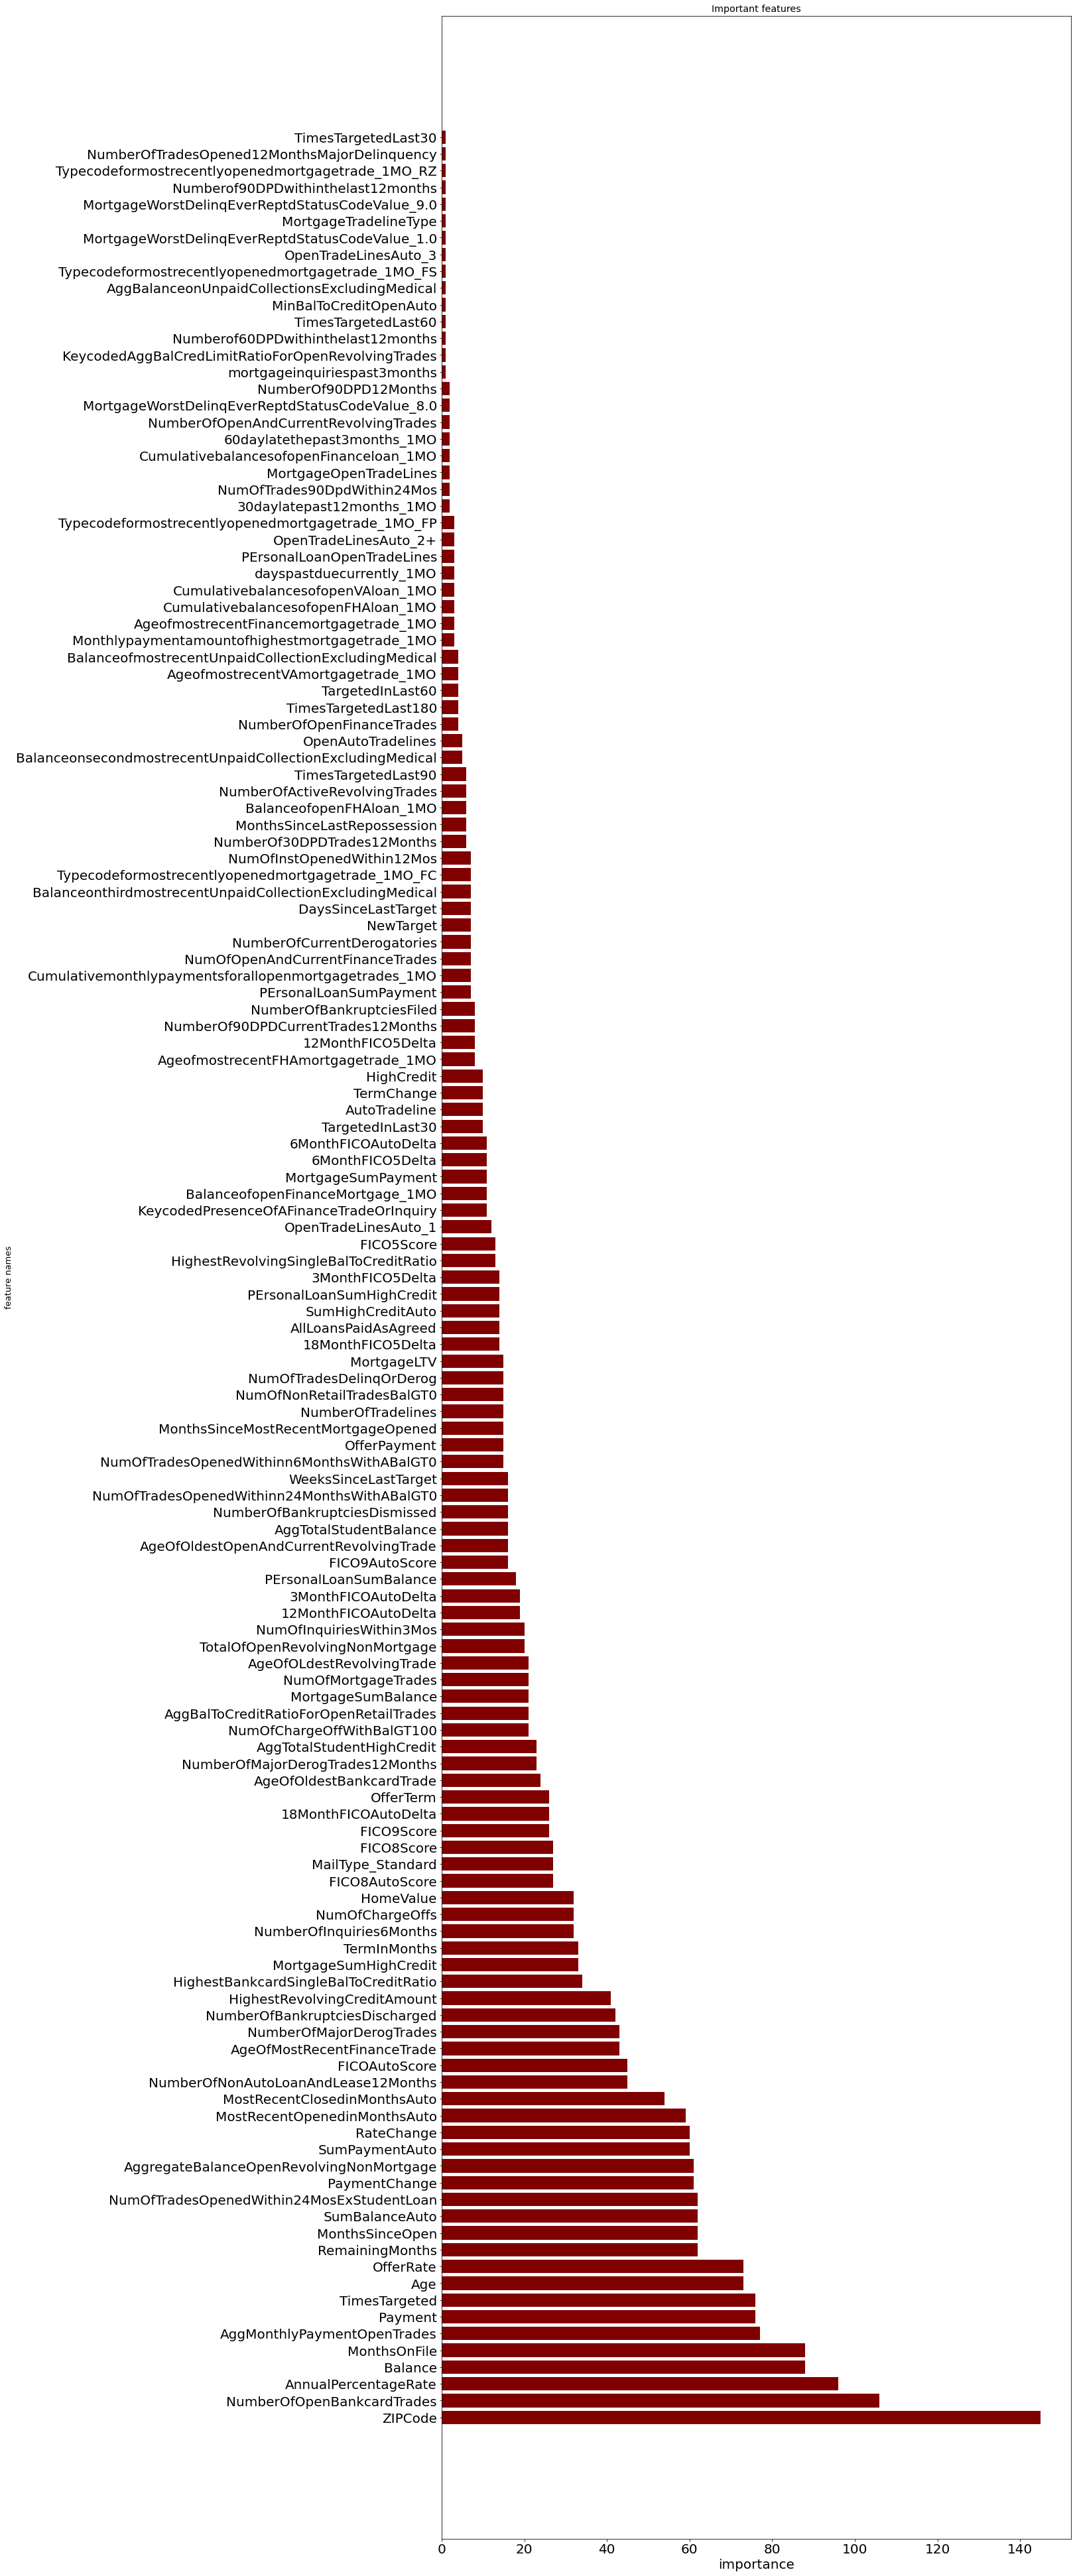

time: 2.09 s (started: 2022-05-09 17:46:29 +04:00)


In [25]:
# Visual representation of features whose importance gain is greater than 0.

fig = plt.figure(figsize = (17, 70))
 

plt.barh(imp_var.cols, imp_var.fea_imp, color ='maroon')
plt.style.use('ggplot')

plt.title('Important features')
plt.ylabel('feature names', fontsize=13, color='black')
plt.yticks(fontsize=20, color='black')
plt.xlabel('importance', fontsize=20, color='black')
plt.xticks(fontsize=20, color='black')
plt.show()

In [26]:
# Manually analyzing and selecting columns that are logically suited for the main problem.

first_50 = ['NumberOfOpenBankcardTrades','AnnualPercentageRate','TimesTargeted','Balance','Age','MonthsOnFile',
          'OfferRate','SumBalanceAuto','MonthsSinceOpen','Payment','AggMonthlyPaymentOpenTrades',
          'NumOfTradesOpenedWithin24MosExStudentLoan','PaymentChange','RemainingMonths','SumPaymentAuto',
          'MostRecentOpenedinMonthsAuto','RateChange','MostRecentClosedinMonthsAuto',
          'AggregateBalanceOpenRevolvingNonMortgage','HighestRevolvingCreditAmount',
          'AgeOfMostRecentFinanceTrade','NumberOfBankruptciesDischarged','FICOAutoScore',
          'HighestBankcardSingleBalToCreditRatio','FICO8AutoScore','NumberOfNonAutoLoanAndLease12Months',
          'NumberOfInquiries6Months','MortgageSumHighCredit','NumOfChargeOffs','TermInMonths',
          'AgeOfOldestBankcardTrade','MailType_Standard','PErsonalLoanSumBalance','3MonthFICOAutoDelta',
          'AgeOfOLdestRevolvingTrade','Monthlypaymentamountofhighestmortgagetrade_1MO',
          'MonthsSinceMostRecentMortgageOpened','NumberOfBankruptciesDismissed','OfferPayment',
          'AgeOfOldestOpenAndCurrentRevolvingTrade','OfferTerm','AggBalToCreditRatioForOpenRetailTrades',
          'NumberOfTradelines','AllLoansPaidAsAgreed','PErsonalLoanSumHighCredit','PErsonalLoanSumPayment',
          'AutoTradeline','KeycodedPresenceOfAFinanceTradeOrInquiry','TermChange', 'NumOfMortgageTrades']

time: 332 µs (started: 2022-05-09 17:46:31 +04:00)


In [27]:
# Filtering out unnecessary features from the important features dataframe. Saving the dataframe

imp_var_first_50 = imp_var[imp_var['cols'].isin(first_50)]
imp_var_first_50.to_csv('../Data/important_50_X.csv', index=False)

time: 12.5 ms (started: 2022-05-09 17:46:31 +04:00)


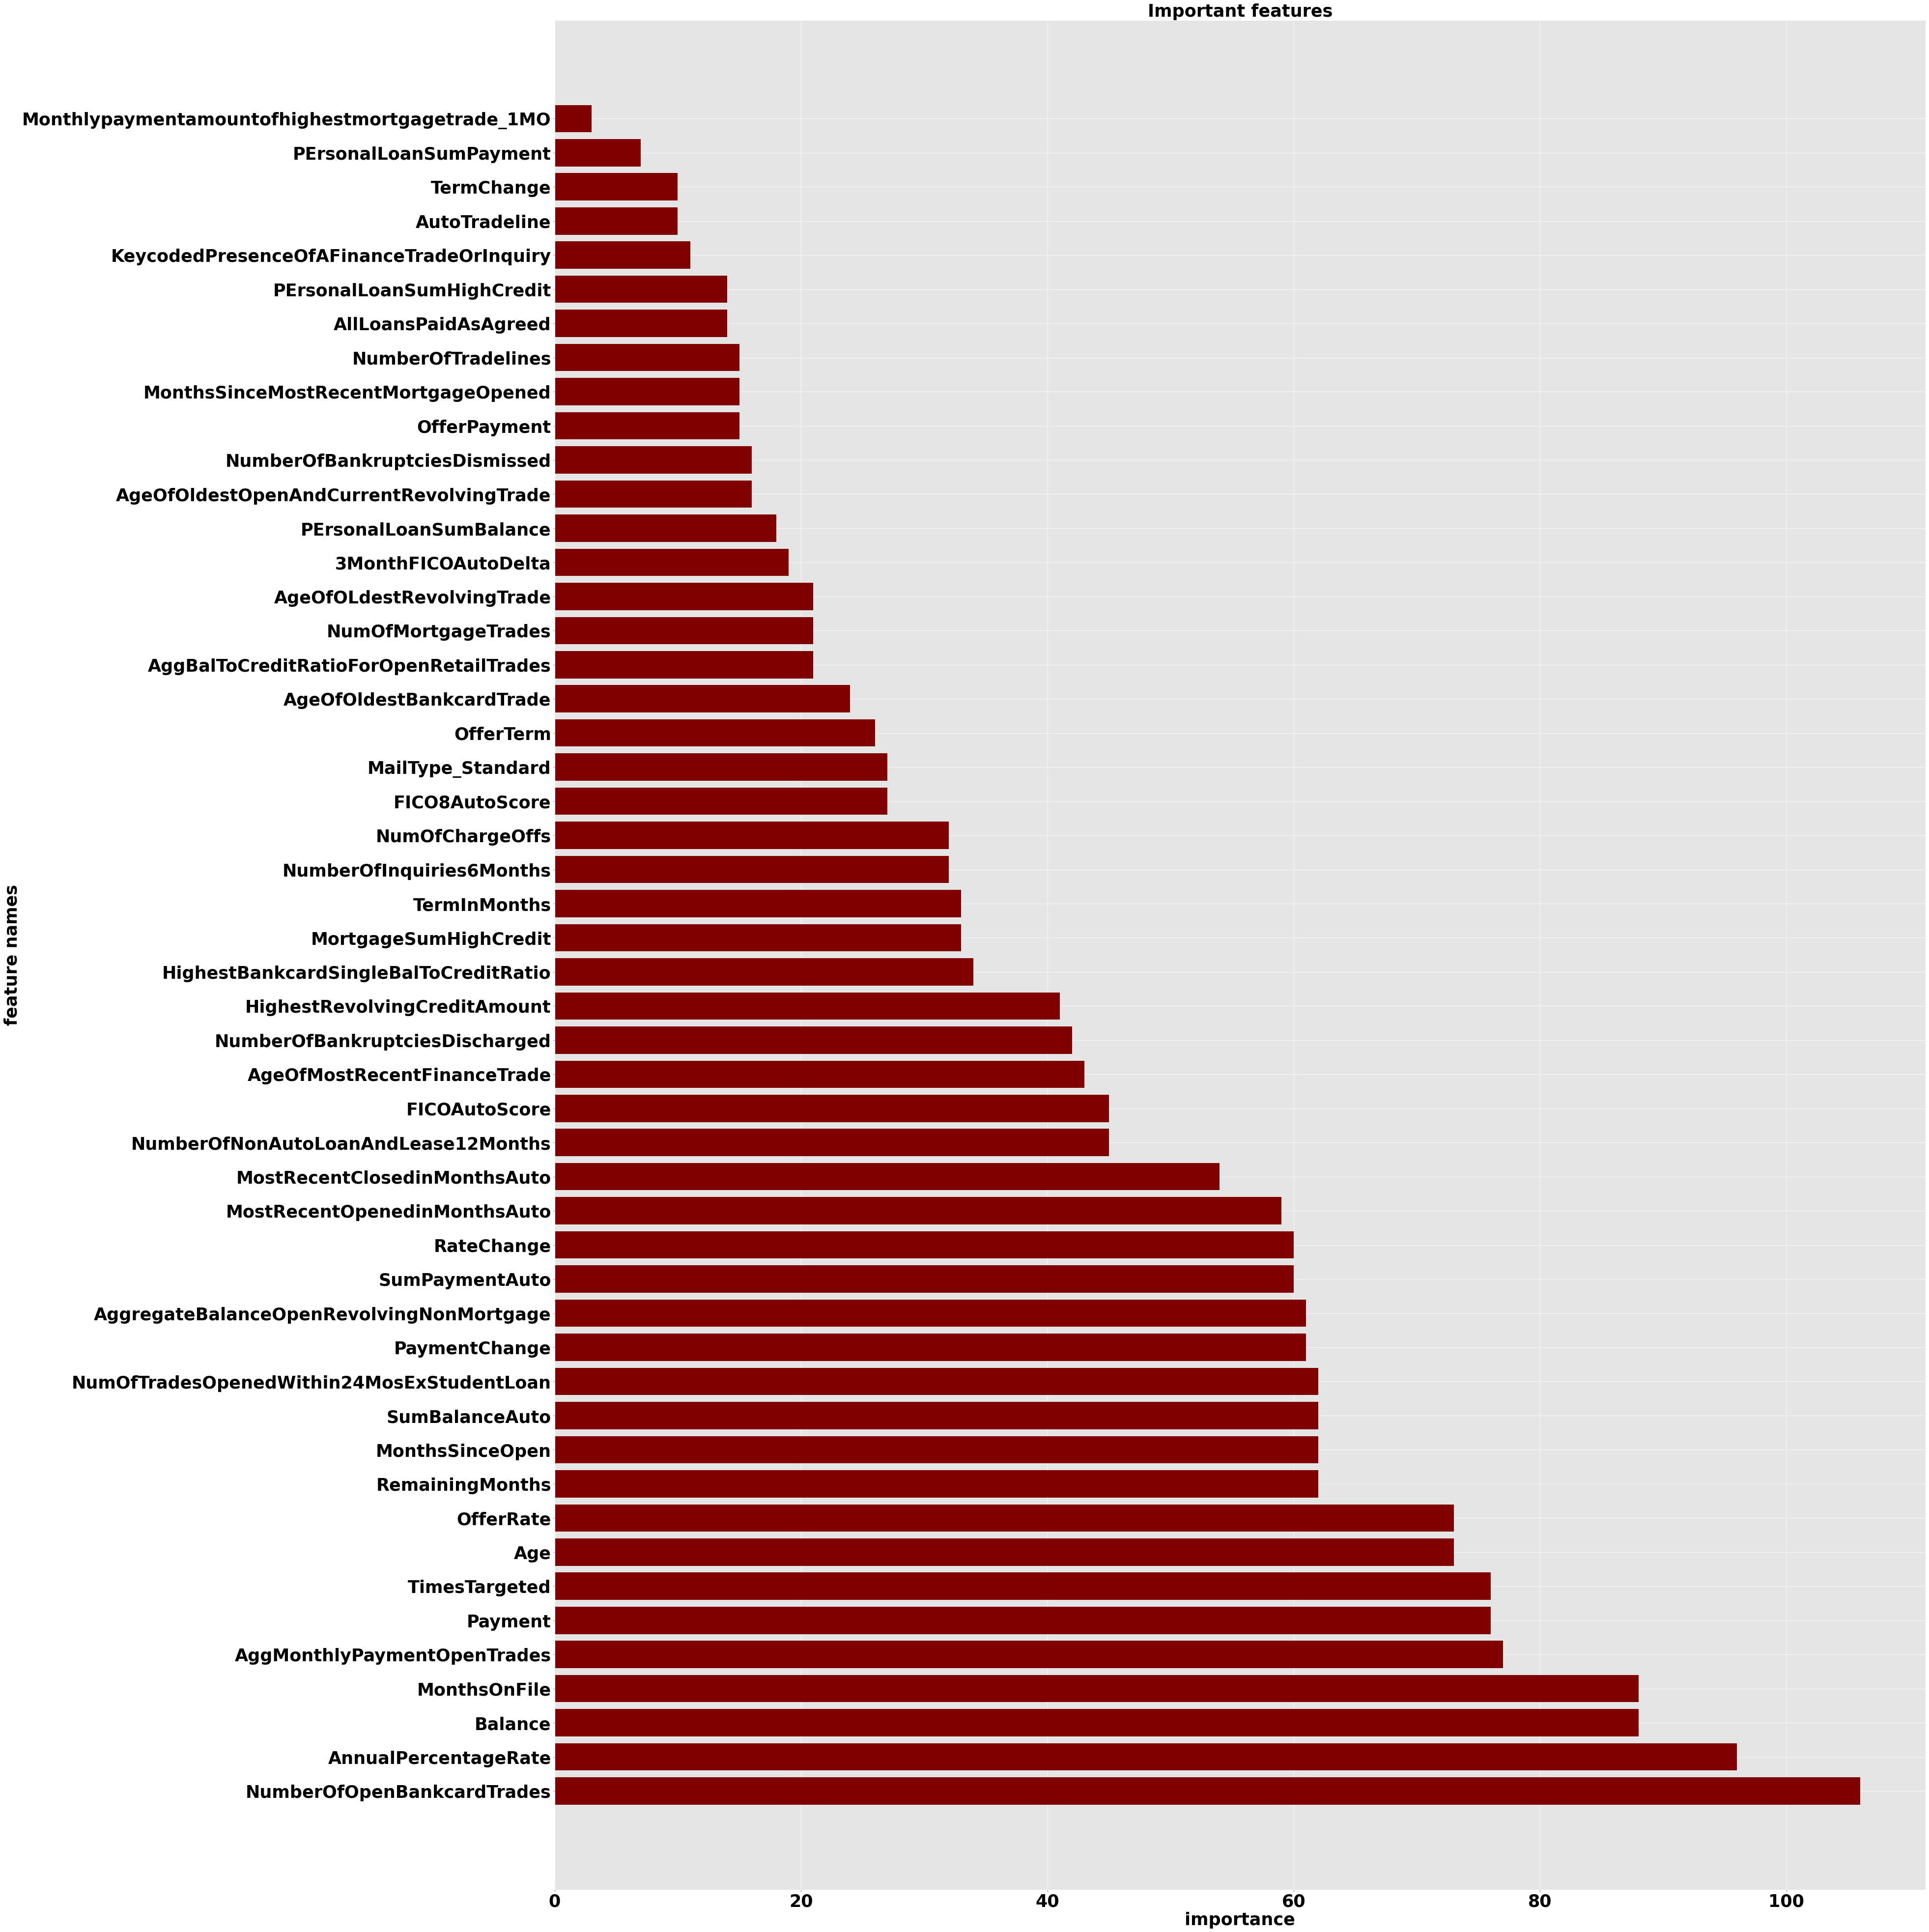

time: 1.11 s (started: 2022-05-09 17:57:41 +04:00)


In [36]:
# Visual representation of the first 50 features that would be used for the further analysis and predictions.

fig = plt.figure(figsize = (50, 70))
 
    
plt.barh(imp_var_first_50.cols, imp_var_first_50.fea_imp, color ='maroon')
plt.style.use('ggplot')

plt.title('Important features', fontsize=35, color='black', weight = 'bold')
plt.ylabel('feature names', fontsize=35, color='black', weight = 'bold')
plt.yticks(fontsize=35, color='black', weight = 'bold')
plt.xlabel('importance', fontsize=35, color='black', weight = 'bold')
plt.xticks(fontsize=35, color='black', weight = 'bold')
plt.show()

In [29]:
# Saving only important features both in train dataset and in test dataset

train_data_important_vars = x_train_lgbm[first_50] 
test_data_important_vars = x_test_lgbm[first_50] 

time: 3.22 s (started: 2022-05-09 17:46:33 +04:00)


In [30]:
# Adding Lead Flag and ZIPCode to the train and test datasets

train_data_important_vars['Lead Flag'] = y_train
train_data_important_vars['ZIPCode'] = train_zip_code

test_data_important_vars['Lead Flag'] = y_test
test_data_important_vars['ZIPCode'] = test_zip_code

time: 428 ms (started: 2022-05-09 17:46:36 +04:00)


In [32]:
# Saving train dataset 

train_data_important_vars.to_csv('../Data/TrainImpVars.csv', index=False)

time: 4min 6s (started: 2022-05-09 17:46:37 +04:00)


In [33]:
# Saving testing dataset

test_data_important_vars.to_csv('../Data/TestImpVars.csv', index=False)

time: 2min 2s (started: 2022-05-09 17:50:43 +04:00)
